<a href="https://colab.research.google.com/github/hadilou/MachineLearning/blob/master/road.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import sys
import random
import math
import re
import time
import numpy as np
from numpy.linalg import inv

import pandas as pd
from numpy import genfromtxt
import cv2
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use("gtk")
#import gc
#import seaborn as sns
%matplotlib inline
#%pylab inline
#pal = sns.color_palette()
import skimage.draw
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

#from PIL import Image
from tqdm import tqdm

In [0]:
# Root directory of the project
ROOT_DIR = os.path.abspath("C:/Users/Kayode Hadilou ADJE/AnacondaProjects/Mask_RCNN")
print(ROOT_DIR)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils

import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log


C:\Users\Kayode Hadilou ADJE\AnacondaProjects\Mask_RCNN


Using TensorFlow backend.


In [0]:

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [0]:
class RoadConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "road"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 28  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_META_SIZE = 41
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 20000

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 100
    
config = RoadConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                41
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [0]:
#@title Default title text

class RoadDataset(utils.Dataset):
    
    def load_road(self, dataset_dir, subset):
        """Load a subset of the Road dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """

        # Add classes. We have only one class to add.
        self.add_class("road",1, "stop")
        self.add_class("road",2,"leftturn")
        self.add_class("road",3,"rightturn")
        self.add_class("road",4,"rail")
        self.add_class("road",5,"35")
        self.add_class("road",6,"forward")
        self.add_class("road",7,"bike")
        self.add_class("road",8,"40")
        self.add_class("road",9,"ped")
        self.add_class("road",10,"xing")
        self.add_class("road",11,"diamond")
        self.add_class("road",12,"car")
        self.add_class("road",13,"pool")
        self.add_class("road",14,"lane")
        self.add_class("road",15,"keep")
        self.add_class("road",16,"clear")
        self.add_class("road",17,"25")
        self.add_class("road",18,"crossing")
        self.add_class("road",19,"X-")
        self.add_class("road",20,"forward&right")
        self.add_class("road",21,"speed")
        self.add_class("road",22,"hump")
        self.add_class("road",23,"30")
        self.add_class("road",24,"slow")
        self.add_class("road",25,"school")
        self.add_class("road",26,"stripe")
        self.add_class("road",27,"forward&left")
        self.add_class("road",28,"yield")
        
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        dataset_dir = dataset_dir + '/'

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        
        
        annotations = pd.read_csv("D:/Datasets/RoadmarkingDataset/New folder/dataset_annotations.txt")
        
        annotations = np.asarray(annotations)
        # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        #annotations = [a for a in annotations if a['label']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            print(a)
            polygons = {
                'all_points_x': [int(a[0]),int(a[2]),int(a[4]),int(a[6])],
                'all_points_y': [int(a[1]),int(a[3]),int(a[5]),int(a[7])],
                'name': 'polygon'
            } 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            dataDIR = "D:/Datasets/RoadmarkingDataset/RoadMarkingDataset/"
            image_path = dataDIR + a[9] #a[9]=a(file_name)
            print(a[9])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "road",
                image_id=a[9],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)
    def load_mask(dataset, image_id):
        """"Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks."""
        
        # If not a road dataset image, delegate to parent class.
        image_info = dataset.image_info[image_id]
        """"if image_info["source"] != "road":
            return super(dataset.__class__, self).load_mask(image_id)"""""

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = dataset.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            #print(info['polygons']['all_points_x'])
            X=info['polygons']['all_points_x']
            Y=info['polygons']['all_points_y']
            rr, cc = skimage.draw.polygon(X,Y)
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "road":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
    


next code builds dataset should be run only once

In [0]:
    def save(filename, output_dir):
        """Resize the image contained in `filename` and save it to the `output_dir`"""
        image = Image.open(os.path.join("D:/Datasets/RoadmarkingDataset/RoadMarkingDataset",filename))
        # Use bilinear interpolation instead of the default "nearest neighbor" method
        image.save(os.path.join(output_dir, filename.split('/')[-1]))
    
    
    
    train_data_dir = os.path.join("D:/Datasets/RoadmarkingDataset/RoadMarkingDataset")
    

    # Get the filenames in each directory (train and test)
    filenames = os.listdir(train_data_dir)
    #print(filenames)
    filenames = [ f for f in filenames if f.endswith('.jpg')]

    # Split the images in 'train_signs' into 60% train and 20% val 20% test
    # Make sure to always shuffle with a fixed seed so that the split is reproducible
    random.seed(230)
    filenames.sort()
    random.shuffle(filenames)

    split = int(0.6 * len(filenames))
    train_filenames = filenames[:split]
    temp = filenames[split:]
    split2 = int(0.2 * len(temp))
    test_filenames = temp[:split2]
    val_filenames = temp[split2:]
     
    filenames = {'train': train_filenames,
                 'val': val_filenames,
                 'test': test_filenames}
    for split in ['train', 'val', 'test']:
        output_dir_split = os.path.join("D:/Datasets/RoadmarkingDataset/RoadMarkingDataset", '{}'.format(split))
        if not os.path.exists(output_dir_split):
            os.mkdir(output_dir_split)
        else:
            print("Warning: dir {} already exists".format(output_dir_split))

        print("Processing {} data, saving preprocessed data to {}".format(split, output_dir_split))
        for filename in tqdm(filenames[split]):
            print(filename)
            save(filename, output_dir_split)

    print("Done building dataset")

Processing train data, saving preprocessed data to D:/Datasets/RoadmarkingDataset/RoadMarkingDataset\train


  0%|                                                                                           | 0/865 [00:00<?, ?it/s]

roadmark_0297.jpg


NameError: ignored

In [0]:
# Training dataset
dataset_train = RoadDataset()
dataset_train.load_road("D:/Datasets/RoadmarkingDataset/RoadMarkingDataset","train")
dataset_train.prepare()

# Validation dataset
dataset_val = RoadDataset()
dataset_val.load_road("D:/Datasets/RoadmarkingDataset/RoadMarkingDataset/test","val")
dataset_val.prepare()

[321.9642330000001 456.40683 433.777863 335.2753600000001 344.327148
 344.327148 317.166656 317.166656 'stop' 'roadmark_0001.jpg']
roadmark_0001.jpg
[313.9775390000001 453.74459800000005 433.777863 329.950928 350.5
 349.265442 317.166656 317.166656 'stop' 'roadmark_0002.jpg']
roadmark_0002.jpg
[307.32196 449.751251 429.78451500000006 325.957581 352.969147 351.734558
 317.166656 320.870361 'stop' 'roadmark_0003.jpg']
roadmark_0003.jpg
[299.335266 452.413483 431.115631 323.2953490000001 359.141968 359.141968
 320.870361 322.10495 'stop' 'roadmark_0004.jpg']
roadmark_0004.jpg
[295.341919 461.731293 431.115631 316.639771 362.845673 361.611115
 322.10495 325.808655 'stop' 'roadmark_0005.jpg']
roadmark_0005.jpg
[287.355255 455.075714 428.4534 311.315308 367.783966 366.549377
 324.574066 330.746918 'stop' 'roadmark_0006.jpg']
roadmark_0006.jpg
[284.6930240000001 455.075714 429.78451500000006 309.984192 373.956787
 370.253082 327.043213 329.51236 'stop' 'roadmark_0007.jpg']
roadmark_0007.jpg
[

In [0]:
def lload_mask(dataset, image_id):
        """"Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks."""
        
        # If not a road dataset image, delegate to parent class.
        image_info = dataset.image_info[image_id]
        """"if image_info["source"] != "road":
            return super(dataset.__class__, self).load_mask(image_id)"""""

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = dataset.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            #print(info['polygons']['all_points_x'])
            X=info['polygons']['all_points_x']
            Y=info['polygons']['all_points_y']
            rr, cc = skimage.draw.polygon(X,Y)
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

In [0]:
#[u,v,f]' = A' [x-250, y, 1]'
x = 1200
y=1800
a = np.array([[0.197907,-0.178787,360.82],[0,-0.00504166,50.9823],[0,-0.000446185,1]])
print(a)
temp = np.array([x-250,y,1])
print(temp)
transform  = np.dot(a.transpose(),temp.transpose())
transform = transform.transpose()

x = transform[0]/transform[2]
y =transform[1]/transform[2]
print(x,y)

#[u/f, v/f] 

[[ 1.97907e-01 -1.78787e-01  3.60820e+02]
 [ 0.00000e+00 -5.04166e-03  5.09823e+01]
 [ 0.00000e+00 -4.46185e-04  1.00000e+00]]
[ 950 1800    1]
0.0004326601190836992 -0.00041174513872041876


In [0]:
print(dataset_train)

TypeError: ignored

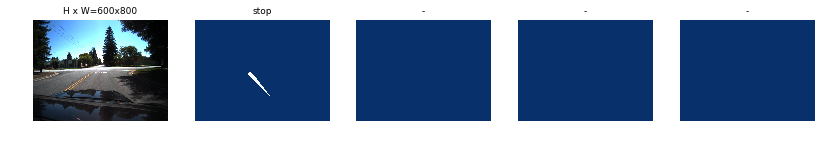

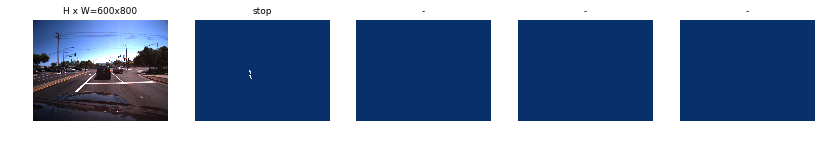

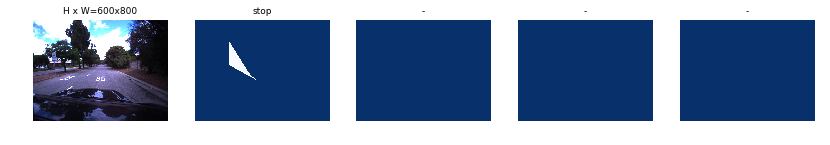

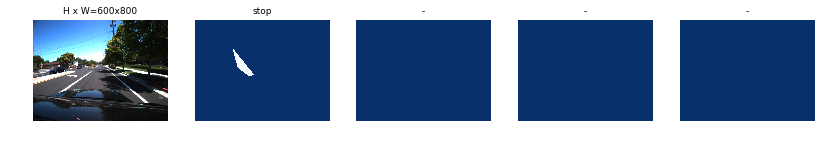

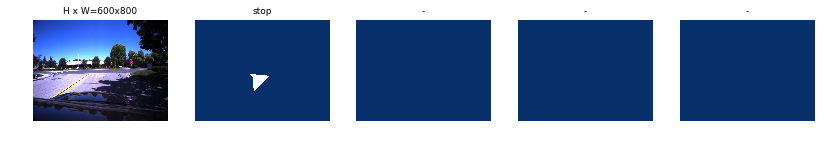

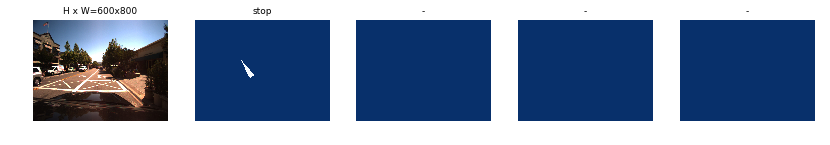

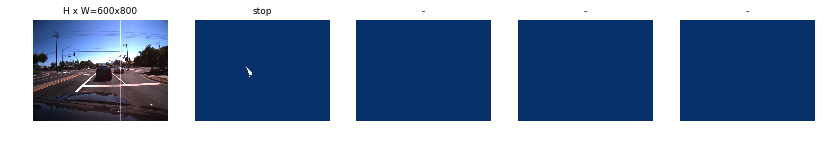

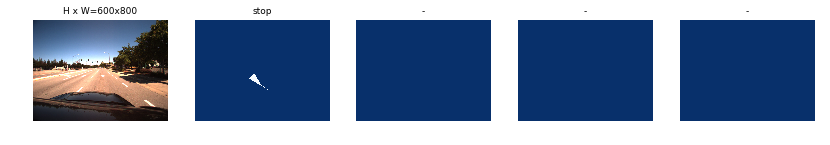

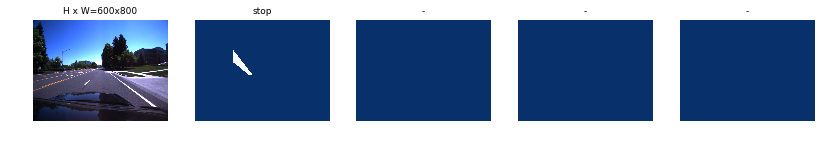

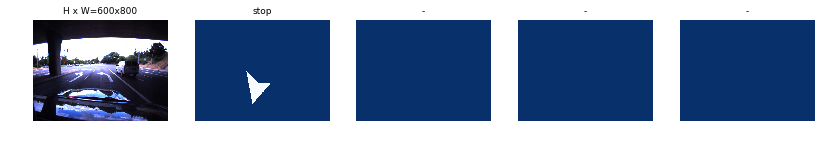

In [0]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 10)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = lload_mask(dataset_train,image_id)
    visualize.display_top_masks(image,mask, class_ids, dataset_train.class_names)

In [0]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [0]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model_.find_last(), by_name=True)

In [0]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\Kayode Hadilou ADJE\AnacondaProjects\Mask_RCNN\logs\road20181128T1930\mask_rcnn_road_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4     

C:\Users\Kayode Hadilou ADJE\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Epoch 1/1
   38/20000 [..............................] - ETA: 435:00:34 - loss: 3.1196 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 1.0629 - mrcnn_class_loss: 0.5495 - mrcnn_bbox_loss: 0.8606 - mrcnn_mask_loss: 0.6127

In [0]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: C:\Users\Kayode Hadilou ADJE\AnacondaProjects\Mask_RCNN\logs\road20181128T1343\mask_rcnn_road_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branc

C:\Users\Kayode Hadilou ADJE\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Epoch 2/2
100/100 [==============================] - 8949s 89s/step - loss: 1.6418 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.6307 - mrcnn_class_loss: 0.0749 - mrcnn_bbox_loss: 0.4279 - mrcnn_mask_loss: 0.4881 - val_loss: 1.6256 - val_rpn_class_loss: 0.0203 - val_rpn_bbox_loss: 0.6518 - val_mrcnn_class_loss: 0.0853 - val_mrcnn_bbox_loss: 0.3892 - val_mrcnn_mask_loss: 0.4789


In [0]:
class InferenceConfig(RoadConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from  C:\Users\Kayode Hadilou ADJE\AnacondaProjects\Mask_RCNN\logs\road20181128T1343\mask_rcnn_road_0002.h5
Re-starting from epoch 2


original_image           shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (41,)                 min:    0.00000  max:  800.00000  float64
gt_class_id              shape: (3,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (3, 4)                min:   43.00000  max:   69.00000  int32
gt_mask                  shape: (128, 128, 3)         min:    0.00000  max:    1.00000  uint8


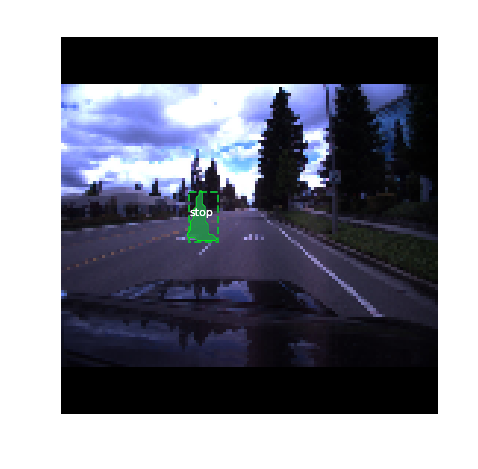

In [0]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


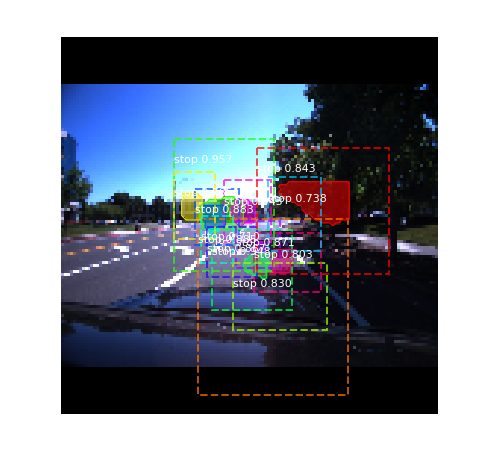

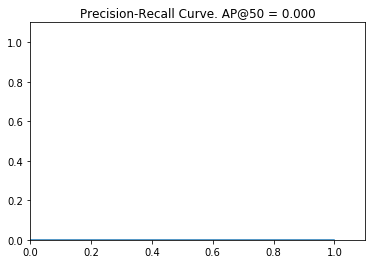

In [0]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

In [0]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.0


the following can only work one. it resize the boundaries in case there are larger than images

In [0]:

def getAnnotations():
    dataDIR = "D:/Datasets/RoadmarkingDataset/RoadMarkingDataset"
    annotationsDIR= "D:/Datasets/RoadmarkingDataset/New folder/dataset_annotations.txt"
    #annotations = genfromtxt(annotationsDIR, delimiter=',',dtype=str)
    df_train = pd.read_csv(annotationsDIR)
    #print((df_train.x1[0]))
    c = 0
    for i in range(0,len(df_train['x1'])):
        if df_train.x1[i] >=600:
            df_train.x1[i] = 590
            print(df_train.x1[i])
    for i in range(0,len(df_train['x2'])):
        if df_train.x2[i] >=600:
            df_train.x2[i] = 590
            print(df_train.x1[i])
            
    df_train.to_csv(annotationsDIR, index=False, encoding='utf8')
getAnnotations()


C:\Users\Kayode Hadilou ADJE\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



590.0
590.0
590.0
590.0
590.0
590.0
590.0
590.0
590.0
590.0
590.0
590.0
590.0
590.0
590.0
590.0
590.0
590.0
590.0
590.0
590.0
590.0
590.0


C:\Users\Kayode Hadilou ADJE\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



522.962585
536.273682
560.2337650000002
514.975891
508.320312
504.32696500000003
514.975891
526.955933
536.273682
558.902649
574.876038
590.0
572.213806
560.2337650000002
506.989197
512.3136599999998
504.32696500000003
510.982544
513.644775
525.624817
536.273682
590.0
590.0
590.0
590.0
590.0
590.0
590.0
590.0
590.0
568.463379
570.294067
575.786011
587.6853639999998
583.108704
592.262024
590.0
590.0
590.0
590.0
590.0
590.0
590.0
590.0
552.902771
539.172791
590.0
590.0
589.515991


In [0]:
dataDIR = "D:/Datasets/RoadmarkingDataset/RoadMarkingDataset"
annotationsDIR= "D:/Datasets/RoadmarkingDataset/New folder/dataset_annotations.txt"
df_train = pd.read_csv(annotationsDIR)
#print(df_train.head())
labels = df_train['label'].apply(lambda x: x.split(' '))
labels

0               [stop]
1               [stop]
2               [stop]
3               [stop]
4               [stop]
5               [stop]
6               [stop]
7               [stop]
8               [stop]
9               [stop]
10          [leftturn]
11          [leftturn]
12          [leftturn]
13          [leftturn]
14          [leftturn]
15          [leftturn]
16          [leftturn]
17         [rightturn]
18          [leftturn]
19          [leftturn]
20         [rightturn]
21         [rightturn]
22          [leftturn]
23          [leftturn]
24         [rightturn]
25          [leftturn]
26          [leftturn]
27          [leftturn]
28         [rightturn]
29          [leftturn]
             ...      
1413           [yield]
1414              [25]
1415           [yield]
1416           [yield]
1417           [yield]
1418           [yield]
1419              [25]
1420              [25]
1421              [25]
1422       [rightturn]
1423    [forward&left]
1424    [forward&left]
1425       

In [0]:
from collections import Counter, defaultdict
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1
print(counts)
data=[go.Bar(x=list(counts.keys()), y=list(counts.values()))]
layout=dict(height=800, width=800, title='Distribution of training labels')
fig=dict(data=data, layout=layout)
py.iplot(data, filename='train-label-dist')
py.show()

In [0]:
com = np.zeros([len(counts)]*2)
for i, l in enumerate(list(counts.keys())):
    for i2, l2 in enumerate(list(counts.keys())):
        c = 0
        cy = 0
        for row in labels.values:
            if l in row:
                c += 1
                if l2 in row: cy += 1
        com[i, i2] = cy / c

data=[go.Heatmap(z=com, x=list(counts.keys()), y=list(counts.keys()))]
layout=go.Layout(height=800, width=800, title='Co-occurence matrix of training labels')
fig=dict(data=data, layout=layout)
py.iplot(data, filename='train-com')
py.show()

AttributeError: ignored